# Predict Sale Price

## Objectives

## Objectives

*   Fit and evaluate a regression model to predict the `SalePrice` of a house.

## Inputs

* outputs/datasets/collection/HeritageHousing.csv
* instructions on which variables to use for data cleaning and feature engineering. They are found on its respectives notebooks.

## Outputs

* Train set (features and target)
* Test set (features and target)
* Data cleaning and Feature Engineering pipeline
* Modeling pipeline
* Features importance plot


---

# Change working directory

* We are assuming you will store the notebooks in a sub folder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/Heritage-Housing-Issues-P5/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/Heritage-Housing-Issues-P5'

## Load Data

In [4]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/HeritageHousing.csv")
    )

print(df.shape)
df.head(3)

(1460, 24)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500


---

## ML Pipeline with all Data

### Cleaning and Feature Engineering

In [5]:
### Data Cleaning
from sklearn.pipeline import Pipeline
from feature_engine.imputation import CategoricalImputer
from feature_engine.imputation import MeanMedianImputer
from feature_engine.imputation import ArbitraryNumberImputer


### Feature Engineering
from feature_engine.creation import MathFeatures
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine.encoding import OrdinalEncoder
from feature_engine.outliers import Winsorizer
from feature_engine import transformation as vt

### Feat Scaling
from sklearn.preprocessing import StandardScaler

### Feat Selection
from sklearn.feature_selection import SelectFromModel

### ML algorithms 
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

def PipelineOptimization(model):
  pipeline_base = Pipeline([
    ### Data Cleaning
    ("ArbitraryNumberImputer",ArbitraryNumberImputer(arbitrary_number=0, 
                                                variables=['2ndFlrSF', 'EnclosedPorch', 'MasVnrArea', 'WoodDeckSF'])),

    ("CategoricalImputer",CategoricalImputer(imputation_method='missing',fill_value='Unf',
                                                variables=['GarageFinish', 'BsmtFinType1'])),

    ("MeanMedianImputer",MeanMedianImputer(imputation_method='median', 
                                                variables=['LotFrontage', 'BedroomAbvGr', 'GarageYrBlt'])),  

    ## ("YearFiller",df['GarageYrBlt'].fillna(df['YearBuilt'])),   

    ### Feature Engineering
    ("MathFeatures",MathFeatures(variables=['1stFlrSF','2ndFlrSF','BsmtFinSF1','BsmtUnfSF','EnclosedPorch',
        'GarageArea','GrLivArea','LotArea','MasVnrArea','OpenPorchSF','TotalBsmtSF','WoodDeckSF'],
        func=['sum'], new_variables_names=['TotalArea'])),

    ("OrdinalCategoricalEncoder",OrdinalEncoder(encoding_method='arbitrary', 
                                                variables = ['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),

    ("LogTransformer",vt.LogTransformer(variables = ['1stFlrSF', 'GrLivArea', 'TotalArea', 'LotArea', 'LotFrontage', ])),

    ("PowerrTransformer",vt.PowerTransformer(variables = ['2ndFlrSF','BsmtFinSF1','BsmtUnfSF','GarageArea','MasVnrArea',
                                                        'OpenPorchSF','TotalBsmtSF','WoodDeckSF'])),

    ("Winsorizer",Winsorizer(capping_method='iqr', tail='both', fold=1.5, 
                                      variables=['GrLivArea', 'TotalArea'])),                                                    

    ("SmartCorrelatedSelection",SmartCorrelatedSelection(variables=None, method="spearman", 
                                                        threshold=0.8, selection_method="variance")),
    
    ("feat_scaling", StandardScaler()),

    ("feat_selection",  SelectFromModel(model)),

    ("model", model),   
    
  ])

  return pipeline_base

/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Custom Class for hyperparameter Optimization

In [6]:
from sklearn.model_selection import GridSearchCV
class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model=  PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

## Split Train Test Set

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(
                                    df.drop(['SalePrice'],axis=1),
                                    df['SalePrice'],
                                    test_size=0.2,
                                    random_state=0
                                    )

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 23) (1168,) 
* Test set: (292, 23) (292,)


In [8]:
X_train.head(3)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd
618,1828,0.0,NaN,Av,48,NaN,1774,NaN,774,Unf,...,11694,90.0,452.0,108,5,9,1822,NaN,2007,2007
870,894,0.0,2.0,No,0,Unf,894,NaN,308,NaN,...,6600,60.0,0.0,0,5,5,894,NaN,1962,1962
92,964,0.0,2.0,No,713,ALQ,163,NaN,432,Unf,...,13360,80.0,0.0,0,7,5,876,NaN,1921,2006


## Grid Search CV - Sklearn

### Use default hyperparameters to find most suitable algorithm

In [9]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

Do a hyperparameter optimization search using default hyperparameters

In [10]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.In

Check results

In [11]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
3,ExtraTreesRegressor,0.714326,0.826957,0.873341,0.057404
2,RandomForestRegressor,0.70525,0.794759,0.836633,0.046156
0,LinearRegression,0.754489,0.790532,0.831704,0.030331
5,GradientBoostingRegressor,0.629836,0.771921,0.827618,0.071977
4,AdaBoostRegressor,0.676189,0.75596,0.802705,0.042531
6,XGBRegressor,0.623751,0.696519,0.748892,0.048599
1,DecisionTreeRegressor,0.494971,0.593073,0.725724,0.082569


### Extensive search on most suitable model to find best hyperparameter configuration

Define model and parameters, for Extensive Search

In [93]:
models_search = {
    "ExtraTreesRegressor":ExtraTreesRegressor(random_state=0),
}

# documentation to help on hyperparameter list: 
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html

# learning_rate : float, default=0.1
# Learning rate shrinks the contribution of each tree by learning_rate. There is a trade-off between learning_rate and n_estimators. Values must be in the range (0.0, inf).

# n_estimators : int, default=100
# The number of boosting stages to perform. Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance. Values must be in the range [1, inf).

# max_depth : int, default=3
# Maximum depth of the individual regression estimators. The maximum depth limits the number of nodes in the tree. Tune this parameter for best performance; the best value depends on the interaction of the input variables. Values must be in the range [1, inf).

# parameters with negative or no improvment: min_samples_leaf, min_weight_fraction_leaf, max_leaf_nodes, min_impurity_decrease

params_search = {
    "ExtraTreesRegressor":{
        'model__n_estimators': [100,300],
        'model__max_depth': [3,10,None],
        'model__min_samples_split': [8], #int or float, default=2, best 8
    }
}

Extensive GridSearch CV

In [94]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 6 candidates, totalling 30 fits


Check results

In [95]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_split,model__n_estimators
5,ExtraTreesRegressor,0.762316,0.842889,0.879284,0.04175,None,8,300
4,ExtraTreesRegressor,0.760675,0.840473,0.879819,0.04189,None,8,100
3,ExtraTreesRegressor,0.757905,0.83845,0.879566,0.042467,10,8,300
2,ExtraTreesRegressor,0.753518,0.836844,0.877146,0.043465,10,8,100
1,ExtraTreesRegressor,0.723826,0.758146,0.788777,0.025216,3,8,300
0,ExtraTreesRegressor,0.728386,0.755404,0.788333,0.023244,3,8,100


Check the best model

In [17]:
best_model = grid_search_summary.iloc[0,0]
best_model

'ExtraTreesRegressor'

Parameters for the best model

In [96]:
grid_search_pipelines[best_model].best_params_

{'model__max_depth': None,
 'model__min_samples_split': 8,
 'model__n_estimators': 300}

Define the best regressor based on search

In [97]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('ArbitraryNumberImputer',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['2ndFlrSF', 'EnclosedPorch',
                                                   'MasVnrArea',
                                                   'WoodDeckSF'])),
                ('CategoricalImputer',
                 CategoricalImputer(fill_value='Unf',
                                    variables=['GarageFinish',
                                               'BsmtFinType1'])),
                ('MeanMedianImputer',
                 MeanMedianImputer(variables=['LotFrontage', 'BedroomAbvGr',
                                              'GarageYrBlt'])),
                (...
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['GrLivArea', 'TotalArea'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance')),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=ExtraTreesRegressor(random_state=0))),
                ('model',
                 ExtraTreesRegressor(min_samples_split=8, n_estimators=300,
                                     random_state=0))])

## Assess feature importance

* These are the 6 most important features in descending order. The model was trained on them: 
['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'GarageArea', 'YearBuilt', 'YearRemodAdd']


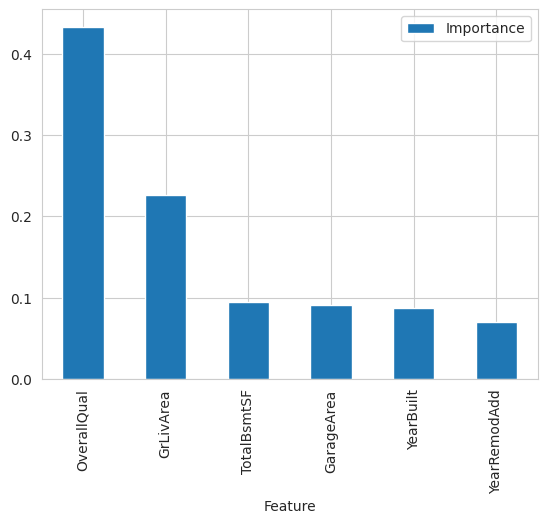

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# after data cleaning and feat engine, the feature may space changes
data_cleaning_feat_eng_steps = 9 # how many data cleaning and feature engineering the pipeline has
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
          'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
          'Importance': best_regressor_pipeline['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

## Evaluate on Train and Test Sets

In [99]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 
import numpy as np

def regression_performance(X_train, y_train, X_test, y_test,pipeline):
	print("Model Evaluation \n")
	print("* Train Set")
	regression_evaluation(X_train,y_train,pipeline)
	print("* Test Set")
	regression_evaluation(X_test,y_test,pipeline)

def regression_evaluation(X,y,pipeline):
  prediction = pipeline.predict(X)
  print('R2 Score:', r2_score(y, prediction).round(3))  
  print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))  
  print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))  
  print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))
  print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test,pipeline, alpha_scatter=0.5):
  pred_train = pipeline.predict(X_train)
  pred_test = pipeline.predict(X_test)


  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
  sns.scatterplot(x=y_train , y=pred_train, alpha=alpha_scatter, ax=axes[0])
  sns.lineplot(x=y_train , y=y_train, color='red', ax=axes[0])
  axes[0].set_xlabel("Actual")
  axes[0].set_ylabel("Predictions")
  axes[0].set_title("Train Set")

  sns.scatterplot(x=y_test , y=pred_test, alpha=alpha_scatter, ax=axes[1])
  sns.lineplot(x=y_test , y=y_test, color='red', ax=axes[1])
  axes[1].set_xlabel("Actual")
  axes[1].set_ylabel("Predictions")
  axes[1].set_title("Test Set")

  plt.show()

Model Evaluation 

* Train Set
R2 Score: 0.973
Mean Absolute Error: 9227.502
Mean Squared Error: 164917514.68
Root Mean Squared Error: 12842.021


* Test Set
R2 Score: 0.87
Mean Absolute Error: 18791.997
Mean Squared Error: 894979718.009
Root Mean Squared Error: 29916.212




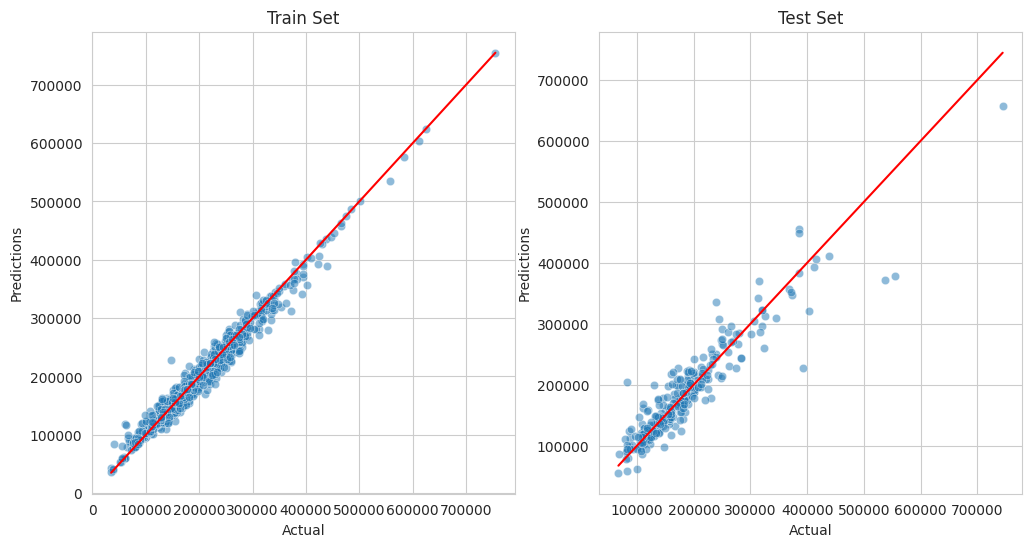

In [22]:
regression_performance(X_train, y_train, X_test, y_test,best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

# Regressor with PCA

In [108]:
pipeline = PipelineOptimization(model=LinearRegression())
pipeline_pca = Pipeline(pipeline.steps[:9])
df_pca = pipeline_pca.fit_transform(df.drop(['SalePrice'],axis=1))

print(df_pca.shape,'\n', type(df_pca))

(1460, 21) 
 <class 'pandas.core.frame.DataFrame'>


Apply PCA separately to the scaled data

* The 21 components explain 100.0% of the data 



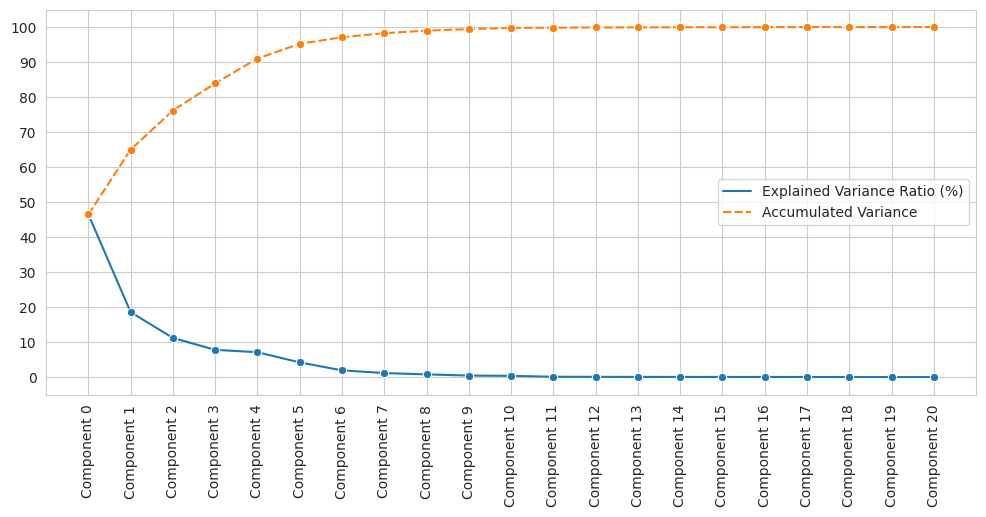

In [111]:
import numpy as np
from sklearn.decomposition import PCA

n_components = 21

def pca_components_analysis(df_pca,n_components): 
    pca = PCA(n_components=n_components).fit(df_pca)
    x_PCA = pca.transform(df_pca) # array with transformed PCA

    ComponentsList = ["Component " + str(number) for number in range(n_components)]
    dfExplVarRatio = pd.DataFrame(
        data= np.round(100 * pca.explained_variance_ratio_ ,3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)'])

    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum() 

    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum()

    print(f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
    plt.figure(figsize=(12,5))
    sns.lineplot(data=dfExplVarRatio,  marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()

pca_components_analysis(df_pca=df_pca,n_components=n_components)

We want 3-4 components to contain as much variation of the data as possible. With 4 components we'll get a little 80% variation which is about ideal.

* The 4 components explain 83.92% of the data 



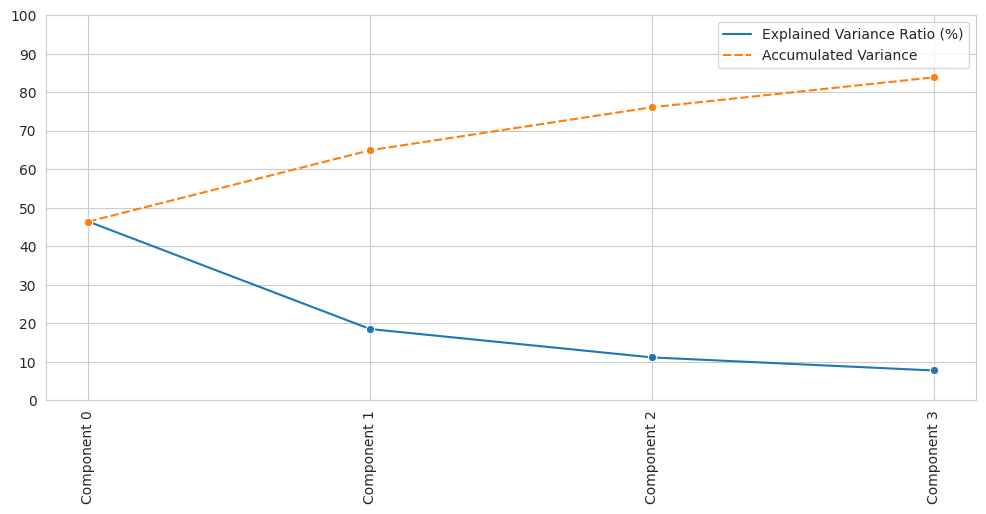

In [114]:
n_components = 4
pca_components_analysis(df_pca=df_pca,n_components=n_components)

---

NOTE

* You may add how many sections you want, as long as it supports your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---

# Push files to Repo

* In case you don't need to push files to Repo, you may replace this section for "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
  # create here your folder
  # os.makedirs(name='')
except Exception as e:
  print(e)


IndentationError: expected an indented block (2852421808.py, line 5)